In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import scipy.optimize as so
from lmfit import minimize, Parameters
from jax import grad, jacobian

## Define and plot goal function

In [2]:
alpha = random.random()
beta  = random.random()
k = 100
mu, sigma = 0, 0.1 # mean and standard deviation
s = list(np.random.normal(mu, sigma, k))
x_k = np.array([i/100 for i in range(100)],dtype=np.float32)
y_k = np.array(list(map(lambda x,delta: alpha*(x/k) + beta + delta, 
                   x_k, s)))

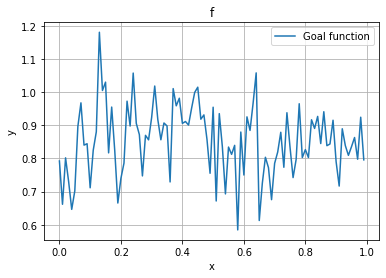

In [3]:
t = np.arange(0.0, 1.0, 0.01)

fig, ax = plt.subplots()
ax.plot(t, y_k,label='Goal function')
ax.legend()
ax.set(xlabel='x', ylabel='y',
       title='f')
ax.grid()
plt.show()


## Approximators and loss function

In [4]:
def rational(X,a,b):
    return a/(1+b*X)

def linear(X,a,b):
    return a*X+b

In [5]:
def loss(func,x_k,y_k,a,b):
    return jnp.sum(jnp.power((func(x_k,a,b)-y_k),2))

## Gradient descent function

In [6]:
def gradient_descent(x_k, y_k, func,x0):
    a,b = x0
    

    D_a = grad(loss,3)
    D_b = grad(loss,4)
    
    L = 0.001  
    epochs = 60

    n = float(len(x_k)) 


    for i in range(epochs): 
        a -= L * D_a(func,x_k,y_k,a,b)  
        b -= L * D_b(func,x_k,y_k,a,b)
    return a,b

## Run gd on linear and rational approximators

/home/alexander.karavaev/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


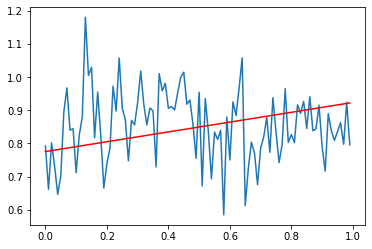

In [7]:
a,b = gradient_descent(x_k,y_k, linear, [0.0,0.0])
Y_pred = a*x_k + b
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

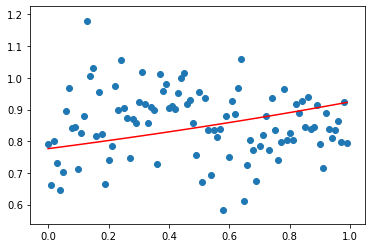

In [8]:
a,b = gradient_descent(x_k,y_k,rational,[0.5,-0.45])
Y_pred = a/(1+b*x_k)
plt.scatter(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

## Conjugate gradient descent

In [9]:
def loss(x0,func,x_k,y_k):
    sum_ = 0
    for x,y in zip(x_k,y_k):
        sum_ += (func(x,x0[0],x0[1])-y)**2
    return sum_

Optimization terminated successfully.
         Current function value: 1.102137
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5
-0.022968157430039438 0.8652109602585547


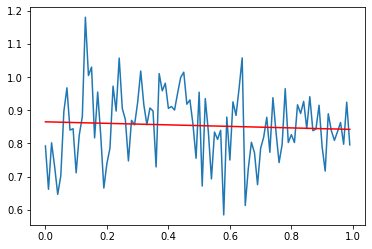

In [10]:
a,b = so.fmin_cg(loss, [0.0,0.3],gtol=0.001,args=(linear,x_k,y_k),disp=True)
print(a,b)
Y_pred = a*x_k + b
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

Optimization terminated successfully.
         Current function value: 1.102287
         Iterations: 8
         Function evaluations: 76
         Gradient evaluations: 19
0.8649154584152878 0.026313642805895283


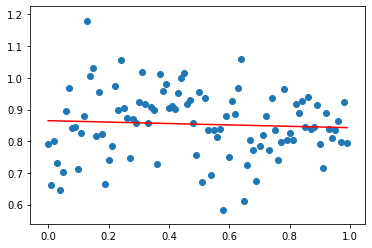

In [11]:
a,b = so.fmin_cg(loss, [0.0,0.3],gtol=0.001,args=(rational,x_k,y_k),disp=True)
print(a,b)
Y_pred = a/(1+b*x_k)
plt.scatter(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

## Newtons method

Optimization terminated successfully.
         Current function value: 1.141938
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 27
         Hessian evaluations: 0
     fun: DeviceArray(1.141938, dtype=float32)
     jac: DeviceArray([ 0.05679323, -1.9237635 ], dtype=float32)
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 5
    njev: 27
  status: 0
 success: True
       x: DeviceArray([0.03758127, 0.8256202 ], dtype=float32)


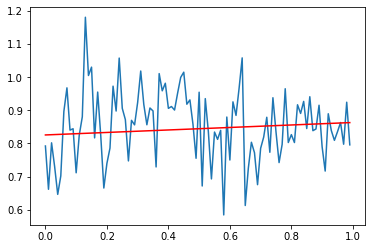

In [12]:
res = so.minimize(loss, [0.0,0.3], args=(linear,x_k, y_k), tol=0.001, method='Newton-CG',jac=jacobian(loss), options={'disp': True})
print(res)
Y_pred = res.x[0]*x_k + res.x[1]
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

In [ ]:
res = so.minimize(loss, [0.0,0.3], args=(rational,x_k, y_k), tol=0.001, method='Newton-CG',jac=jacobian(loss), options={'disp': True})
print(res)
Y_pred = res.x[0]/(1+res.x[1]*x_k)
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

## Levenberg-Marquardt algorithm

In [ ]:
def lm_loss(params, func, x_k,y_k):
    a = params['a'].value
    b = params['b'].value
    sum_ = 0
    for x, y in zip(x_k, y_k):
        sum_ += (func(x, a, b) - y) ** 2
    return sum_


In [ ]:
param = Parameters()
param.add('a', value=float(0.0), min=-100, max=100)
param.add('b', value=float(0.0), min=-100, max=100)
res = minimize(lm_loss, param, args=(linear,x_k, y_k), method='lm')
Y_pred = res.params['a'].value*x_k + res.params['b'].value
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

In [ ]:
res

In [ ]:
param = Parameters()
param.add('a', value=float(0.0), min=-100, max=100)
param.add('b', value=float(0.0), min=-100, max=100)
res = minimize(lm_loss, param, args=(rational,x_k, y_k), method='lm')
Y_pred = res.params['a'].value/(1+res.params['b'].value*x_k)
plt.plot(x_k, y_k)
plt.plot(x_k, Y_pred, color='red') # predicted
plt.show()

In [ ]:
res